In [1]:
import pandas as pd
import numpy as np
import fnmatch 
import os 

In [47]:
def read_ratings(filespath='../data/small_dataset/'):
    pattern = 'revs_*.csv'
    print('Pattern :', pattern )

    files = os.listdir(filespath) 
    dfs_files = []
    for name in files: 
        if fnmatch.fnmatch(name, pattern):
            dfs_files.append(name)
    dfs_files
    dfs_paths = []
    for file in dfs_files:
        dfs_paths.append(filespath + file)

    revs_dfs = []
    for file in dfs_paths:
        revs_dfs.append(pd.read_csv(file))
    print(len(revs_dfs))
    revs_df = pd.concat(revs_dfs[0:200])

    revs_df['UserID'] = revs_df.user_link.astype('category').cat.codes

    revs_df.info()

    revsdf = revs_df[['isbn','UserID','ranking']]

    ratings_df = revsdf.rename(columns={"ranking":"Rating", 'isbn':'ISBN'})

    #droping raws with UserID == 0
    ratings_df.drop(ratings_df[ratings_df['UserID']==0].index, axis=0,inplace=True)
    ratings_df.drop(ratings_df[ratings_df['Rating']==0].index, axis=0,inplace=True)
    
    return ratings_df

In [32]:
ratings_s_df = read_ratings()

Pattern : revs_*.csv
94
[    Unnamed: 0       isbn                                          user_link  \
0            0  802714625          http://goodreads.com/user/show/6896-peter   
1            1  802714625         http://goodreads.com/user/show/8079403-max   
2            2  802714625  http://goodreads.com/user/show/37107782-pramod...   
3            3  802714625  http://goodreads.com/user/show/79757330-philip...   
4            4  802714625    http://goodreads.com/user/show/20498957-claudia   
5            5  802714625      http://goodreads.com/user/show/50297885-joy-d   
6            6  802714625     http://goodreads.com/user/show/51291-william-t   
7            7  802714625       http://goodreads.com/user/show/45287334-john   
8            8  802714625      http://goodreads.com/user/show/1627983-mahlon   
9            9  802714625  http://goodreads.com/user/show/793473-clif-hos...   
10          10  802714625   http://goodreads.com/user/show/13954899-kathleen   
11          11 

In [33]:
len(ratings_s_df['ISBN'].unique())

93

In [11]:
ratings_df.describe()

,UserID,Rating
count,4406.000000,4406.000000
mean,6913.781207,3.960508
std,4002.581711,1.027558
min,5.000000,1.000000
25%,3527.000000,3.000000
50%,6845.000000,4.000000
75%,10373.750000,5.000000
max,13928.000000,5.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3d666dd90>,
      dtype=object)

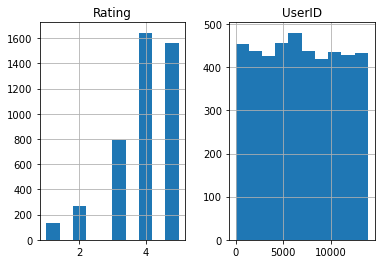

In [13]:
ratings_s_df.hist()

In [48]:
ratings_b_df = read_ratings('../data/big_dataset/')

Pattern : revs_*.csv
974
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14692 entries, 0 to 299
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  14692 non-null  int64 
 1   isbn        14692 non-null  object
 2   user_link   14692 non-null  object
 3   ranking     14692 non-null  int64 
 4   review      14692 non-null  object
 5   UserID      14692 non-null  int16 
dtypes: int16(1), int64(2), object(3)
memory usage: 717.4+ KB


In [49]:
len(ratings_b_df['ISBN'].unique())

54